# Qubit emulator

This example shows a basic demonstration of qubit emulation, including single shot readout fidelity, T1, and Rabi oscillation.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from hist_analysis import *
from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm
from random import *
import seaborn as sns

In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('../firmware/qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.175
	Firmware timestamp: Wed Sep  6 15:36:36 2023

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 2, 32-

In [3]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

In [4]:
#soc['tprocs'][0]

# Set up your resonator

In [5]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


fr = 500
### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : fr}
cfg['nstep'] = 1 # 3
cfg['sweep_time'] = 7 # should be a little longer than readout time (5 us)
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 500 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 66
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 7
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 6144, slope = 6144, steps = 1, wait = 66
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


In [6]:
class VnaProgram(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=2)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],
                             sel     = self.cfg['ro_sel'],
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="oneshot")
        
        self.synci(200)  # give processor some time to configure pulses
        
        # Trigger resonator.
        if self.cfg['qubit_jump']:
            self.trigger(pins=[4,5,6,7,8,9,10,11],t=self.us2cycles(0))
    
    def body(self):
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset']),
                     )

# Resonator spectroscopy

Sweep Parameters
* fstart = 490.0 MHz
* fstop  = 510.0 MHz
* N      = 1500
* fr     = 0.013342228152112057 MHz


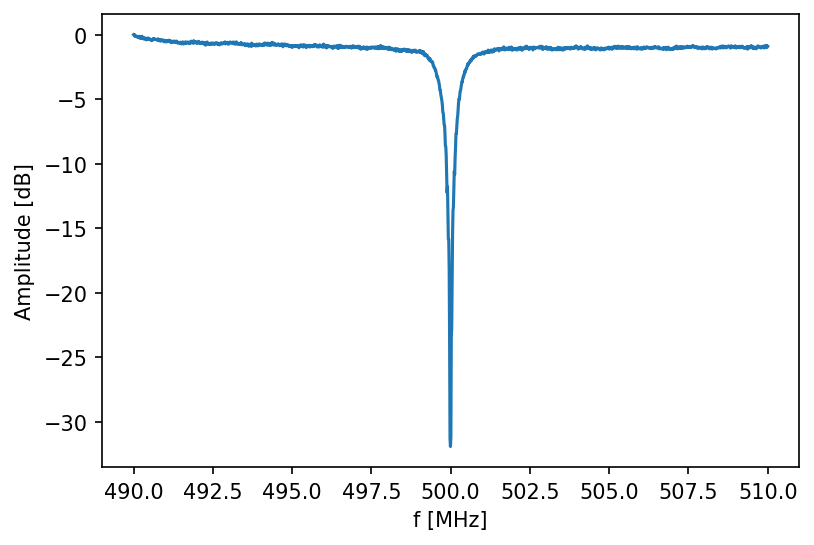

In [7]:
# Frequency sweep.
fc = fr
df = 20
fstart = fc - df/2
fstop = fc + df/2
N = 1500
freqs = np.linspace(start=fstart, stop=fstop, num=N)
print('Sweep Parameters')
print('* fstart = {} MHz'.format(fstart))
print('* fstop  = {} MHz'.format(fstop))
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(freqs[1]-freqs[0]))

config={"gen_ch"      : 2,
        "reps"        : 1,
        "pulse_length": 15,
        "pulse_gain"  : 15000, # [DAC units]
        "pulse_freq"  : fr, # [MHz]
        "qubit_jump"  : True
       }

ro_cfg = {
    "ro_ch"     : 6,
    "ro_length" : 10,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

xi_v = np.zeros(len(freqs))
xq_v = np.zeros(len(freqs))
for i,f in enumerate(freqs):
    config['pulse_freq'] = f
    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    xi,xq = res[1].item(),res[2].item()
    
    xi_v[i] = xi
    xq_v[i] = xq
    
x = xi_v + 1j*xq_v
a = np.abs(x)
phi = np.angle(x)

#############
### Plots ###
#############
plt.figure(dpi=150)
plt.plot(freqs,20*np.log10(a/np.max(a)))
plt.xlabel('f [MHz]')
plt.ylabel('Amplitude [dB]');

# Single shot readout, no T1 decay

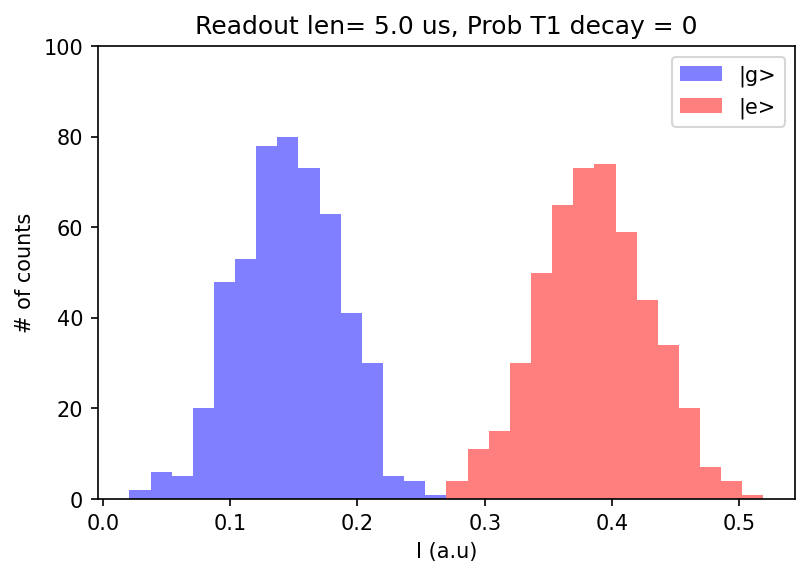

In [8]:
#####################################
### No T1 decay ###
#####################################

config={"gen_ch"      : 2,
        "reps"        : 1,
        "pulse_length": 15,
        "pulse_gain"  : 15000, # [DAC units]
        "pulse_freq"  : fr, # [MHz]
        "qubit_jump"  : True
       }

ro_cfg = {
    "ro_ch"     : 6,
    "ro_length" : 5,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

# Number of points.
N = 1000

i_v = np.zeros(N)
q_v = np.zeros(N)
a_v = np.zeros(N)
i0 = []
i1 = []
q0 = []
q1 = []
a0 = []
a1 = []
for i in range(N):
    # Decide if resonator will jump.
    if random()<0.5:
        config['qubit_jump'] = True
    else:
        config['qubit_jump'] = False

    # Execute program.
    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    xi,xq = res[1].item(),res[2].item()

    xx = xi + 1j*xq
    i_v[i] = xi
    q_v[i] = xq
    a_v[i] = np.abs(xx)
#     phi_v[i] = np.angle(xx) + gauss(mu=0,sigma=0.05)

    if config['qubit_jump']:
        i1.append(i_v[i])
        q1.append(q_v[i])
        a1.append(a_v[i])
    else:
        i0.append(i_v[i])
        q0.append(q_v[i])
        a0.append(a_v[i])

plt.figure(dpi=150)
bins=np.histogram(np.hstack((i0,i1)), bins=30)[1] #get the bin edges
plt.title('Readout len= %.1f us,' %config['ro_length'] + ' Prob T1 decay = 0')
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.ylim(0,100)
plt.hist(i0, bins,color='b', alpha=0.5,label='|g>')
plt.hist(i1, bins,color='r', alpha=0.5,label='|e>')
plt.legend();

# Single shot readout, small amount of T1 decay

When a qubit decays from its excited state to its ground state, its readout resonator jumps back from “e”to “g” instantaneously at random times given by a Poisson distribution with a time scale set by the qubit’s T1 time. We can specify the amount of T1 decay we want by specifying the probability for the resonator to jump: `prob_t1`

Try this demo out with more and more T1 decay.

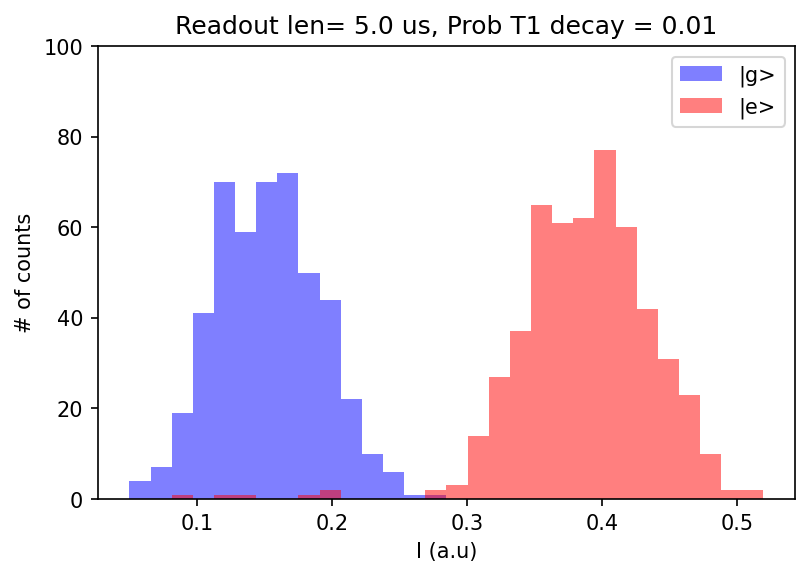

In [21]:
#####################################
### Add a small amount of T1 decay ###
#####################################
prob_t1 = 0.01

config={"gen_ch"      : 2,
        "reps"        : 1,
        "pulse_length": 15,
        "pulse_gain"  : 15000, # [DAC units]
        "pulse_freq"  : fr, # [MHz]
        "qubit_jump"  : True
       }

ro_cfg = {
    "ro_ch"     : 6,
    "ro_length" : 5,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

# Number of points.
N = 1000

i_v = np.zeros(N)
q_v = np.zeros(N)
a_v = np.zeros(N)
i0 = []
i1 = []
q0 = []
q1 = []
a0 = []
a1 = []
for i in range(N):
    # Set resonator decay time.
    t1 = 7

    # Decide if resonator will jump.
    if random()<0.5:
        config['qubit_jump'] = True
        # Set T1 decay to happen
        if random()<prob_t1:
            t1 = 1
    else:
        config['qubit_jump'] = False

    # Set resonator.
#   simu.enable(fr, t=tr, N=1)
    cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t1}
    simu.set_resonator(cfg)
 
    # Execute program.
    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    xi,xq = res[1].item(),res[2].item()

    xx = xi + 1j*xq
    i_v[i] = xi
    q_v[i] = xq
    a_v[i] = np.abs(xx)
#     phi_v[i] = np.angle(xx) + gauss(mu=0,sigma=0.05)

    if config['qubit_jump']:
        i1.append(i_v[i])
        q1.append(q_v[i])
        a1.append(a_v[i])
    else:
        i0.append(i_v[i])
        q0.append(q_v[i])
        a0.append(a_v[i])

plt.figure(dpi=150)
bins=np.histogram(np.hstack((i0,i1)), bins=30)[1] #get the bin edges
plt.title('Readout len= %.1f us,' %config['ro_length'] + ' Prob T1 decay = %.2f' %prob_t1)
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.ylim(0,100)
plt.hist(i0, bins, color='b', alpha=0.5,label='|g>')
plt.hist(i1, bins, color='r', alpha=0.5,label='|e>')
plt.legend();

# Rotate data into I quadrature and compute readout fidelity

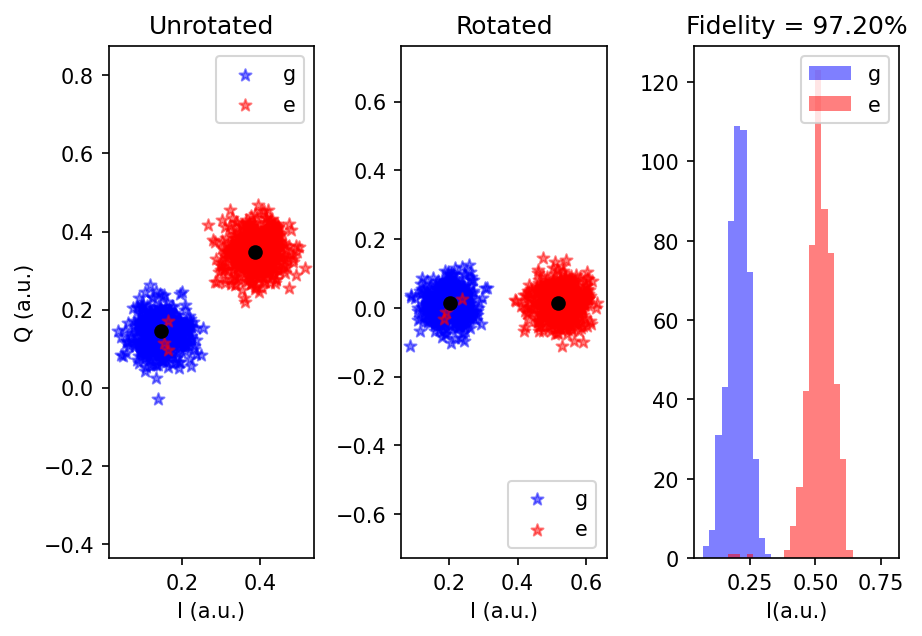

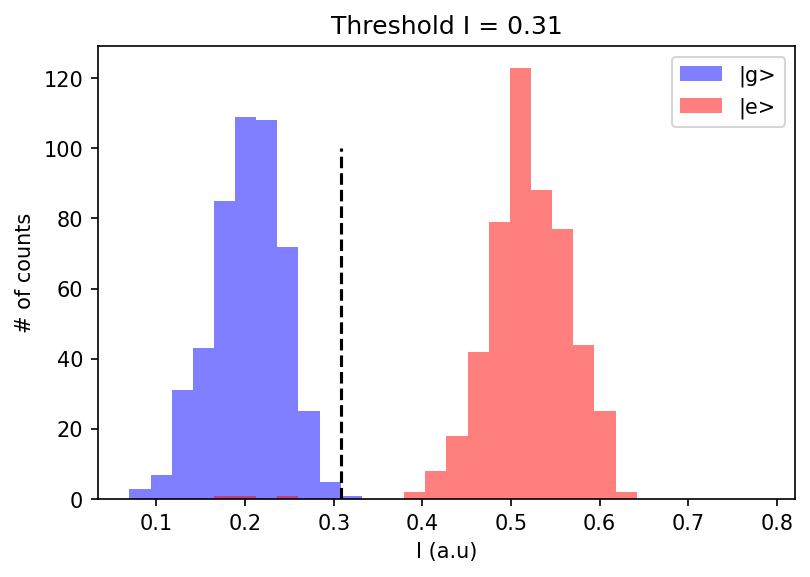

In [10]:
#####################################
### Compute readout fidelity with a small amount of T1 decay ###
#####################################

#Convert lists to arrays
i0 = np.array(i0)
q0 = np.array(q0)
i1 = np.array(i1)
q1 = np.array(q1)

plt.figure(dpi=150)
fid, thresh, theta, xlims = hist_process(data=[i0,q0,i1,q1],numbins=30);

plt.figure(dpi=150)
i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
bins=np.histogram(np.hstack((i0_rot,i1_rot)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.vlines(thresh,ymin=0,ymax=100,color='black',linestyle='--')
plt.hist(i0_rot, bins=30, range=xlims, color='b', alpha=0.5,label='|g>')
plt.hist(i1_rot, bins=30, range=xlims, color='r', alpha=0.5,label='|e>')
plt.title("Threshold I = %.2f"%thresh)
plt.legend();

This threshold value is good until you re-set the resonators or re-set the firmware. Re-running the above two cells will result in distributions with similar thresholds. Re-run `Single shot readout, small amount of T1 decay` cell, first, then this one.

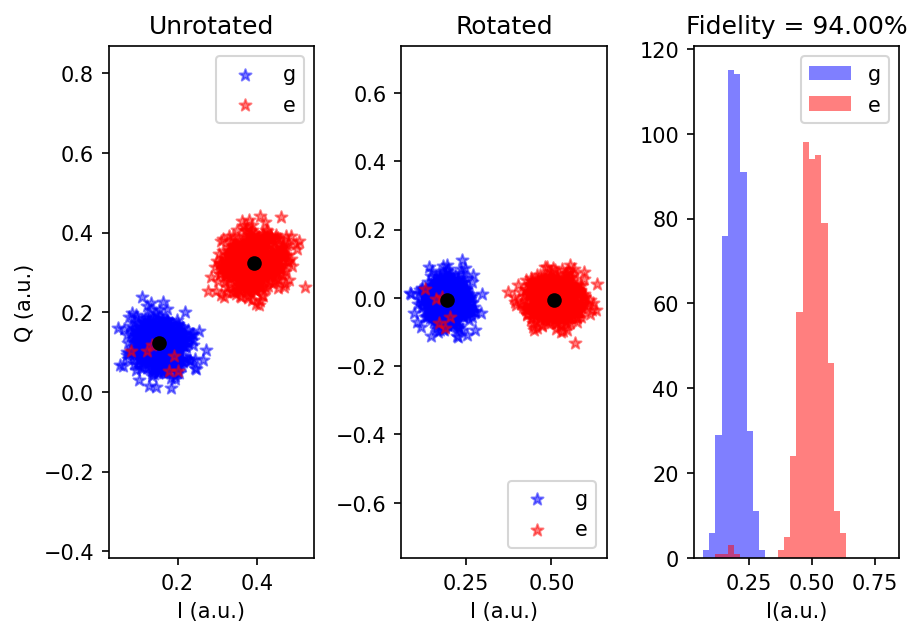

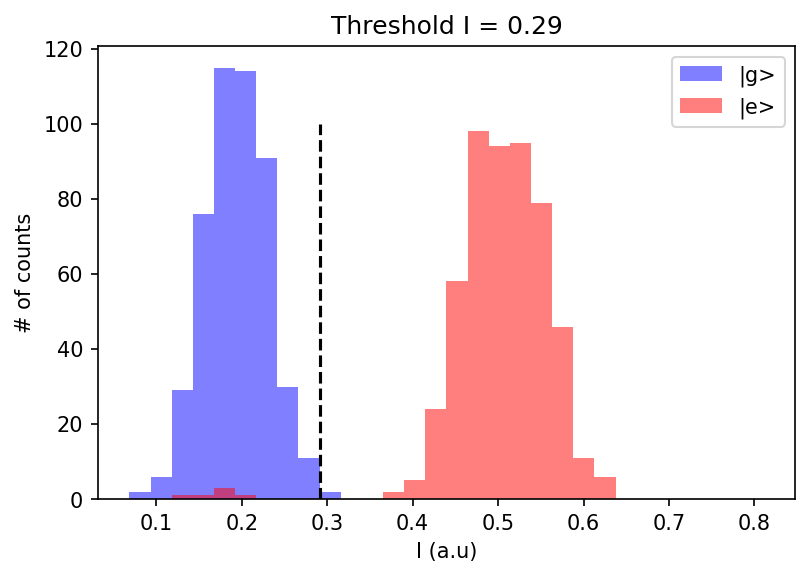

In [22]:
#####################################
### Compute readout fidelity with a small amount of T1 decay ###
#####################################

#Convert lists to arrays
i0 = np.array(i0)
q0 = np.array(q0)
i1 = np.array(i1)
q1 = np.array(q1)

plt.figure(dpi=150)
fid, thresh, theta, xlims = hist_process(data=[i0,q0,i1,q1],numbins=30);

plt.figure(dpi=150)
i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
bins=np.histogram(np.hstack((i0_rot,i1_rot)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.vlines(thresh,ymin=0,ymax=100,color='black',linestyle='--')
plt.hist(i0_rot, bins=30, range=xlims, color='b', alpha=0.5,label='|g>')
plt.hist(i1_rot, bins=30, range=xlims, color='r', alpha=0.5,label='|e>')
plt.title("Threshold I = %.2f"%thresh)
plt.legend();

# T1 decay curve

You've already computed the readout fidelity given an amount of T1 decay to obtain `threshold`, `theta` values. Next, choose the `T1` time of your emulated qubit. Then you will be ready to emulate the T1 decay curve.

In [12]:
#####################################
### Simulate T1 decay curve ###
#####################################

def T1_dist(t,T1):
    p = np.exp(-t/T1)
    return p

#####################################
#####################################

## You've already calibrated your single shot readout
thresh_calib = thresh
theta_calib = theta
print("Calibrated threshold = " + str(thresh_calib) + ", theta = " + str(theta_calib))

## Choose your qubit's T1 
T1 = 2 # a.u.
print("T1 is 2 (in arbitrary units)")

Calibrated threshold = 0.30788850050968003, theta = -0.7000602057283912
T1 is 2 (in arbitrary units)


In [13]:
#####################################
### Now, simulate T1 decay curve using those calibrated values ###
#####################################

N= 100

P_es= []
ts = range(0,10)
# Loop over number of T1 experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator decay time.
        t1 = 7

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            # Set T1 decay to happen
            if random()>T1_dist(t,T1):
                t1 = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
    #   simu.enable(fr, t=tr, N=1)
        cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t1}
        simu.set_resonator(cfg)
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

wait time (a.u.) =  0
wait time (a.u.) =  1
wait time (a.u.) =  2
wait time (a.u.) =  3
wait time (a.u.) =  4
wait time (a.u.) =  5
wait time (a.u.) =  6
wait time (a.u.) =  7
wait time (a.u.) =  8
wait time (a.u.) =  9


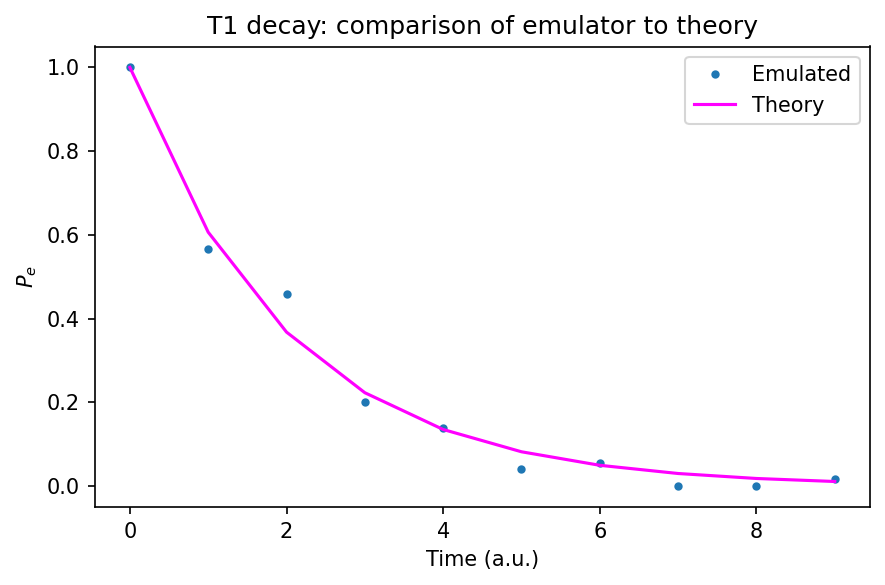

In [14]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts,[T1_dist(t,T1) for t in ts],'-',color='magenta',label="Theory")
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("T1 decay: comparison of emulator to theory")
plt.tight_layout();

Try obtaining this curve again with better and worse readout fidelity. Are the results what you expect?

# Rabi oscillations

Similarly, we can use our previously calibrated readout values to emulate qubit Rabi oscillations.

In [15]:
#####################################
### Simulate Rabi oscillation ###
#####################################

def Rabi_dist(t,Omega):
    p = 0.5*np.cos(Omega*t)+0.5
    return p

#####################################
### Now, simulate Rabi oscillation using the previously calibrated readout values ###
#####################################

N= 100

thresh_calib = thresh
theta_calib = theta
Omega = 0.5

print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))
print('* Omega     = {} (a.u.)'.format(Omega))


P_es= []
ts = range(0,10)
# Loop over number of Rabi experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator decay time.
        t1 = 7

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            if random()>Rabi_dist(t,Omega):
                t1 = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
    #   simu.enable(fr, t=tr, N=1)
        cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t1}
        simu.set_resonator(cfg)
 
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

Experiment Parameters
* N      = 100
* fr     = 500 MHz
* Omega     = 0.5 (a.u.)
wait time (a.u.) =  0
wait time (a.u.) =  1
wait time (a.u.) =  2
wait time (a.u.) =  3
wait time (a.u.) =  4
wait time (a.u.) =  5
wait time (a.u.) =  6
wait time (a.u.) =  7
wait time (a.u.) =  8
wait time (a.u.) =  9


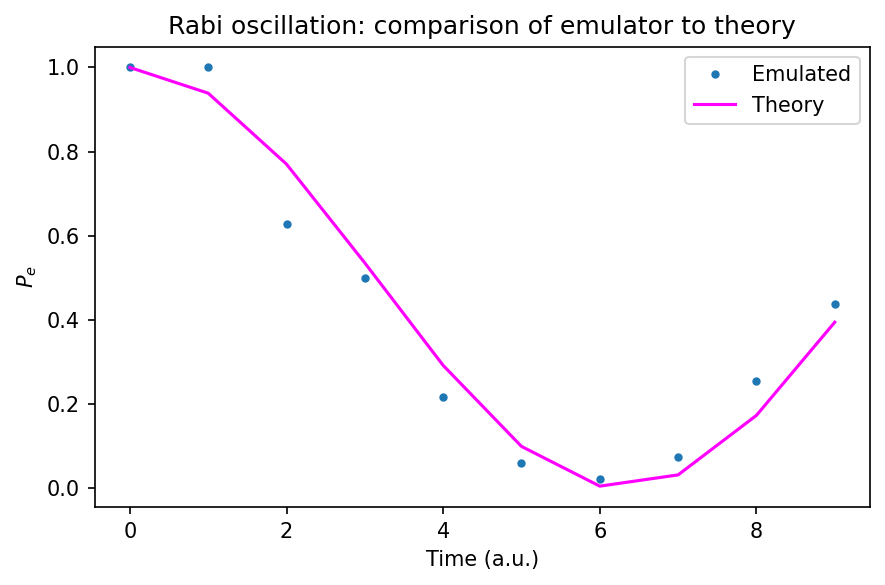

In [16]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts,[Rabi_dist(t,Omega) for t in ts],'-',color='magenta',label="Theory")
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Rabi oscillation: comparison of emulator to theory")
plt.tight_layout();

# Ramsey fringes

Similarly, we can use our previously calibrated readout values to emulate qubit Rabi oscillations.

In [19]:
#####################################
### Simulate Rabi oscillation ###
#####################################

def T2R_dist(t,T2R,Detuning):
    p = 0.5*np.exp(-t/T2R)*np.cos(Detuning*t)+0.5
    return p

#####################################
### Now, simulate Ramsey fringes using the previously calibrated readout values ###
#####################################

N= 100

thresh_calib = thresh
theta_calib = theta
Detuning = 10 # Detuning
T2R = 6

print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))
print('* Detuning     = {} (a.u.)'.format(Omega))
print('* T2R     = {} (a.u.)'.format(T2R))


P_es= []
ts = np.arange(0,13,0.5)
# Loop over number of Rabi experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator decay time.
        t1 = 7

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            if random()>T2R_dist(t,T2R,Detuning):
                t1 = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
    #   simu.enable(fr, t=tr, N=1)
        cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t1}
        simu.set_resonator(cfg)
 
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

Experiment Parameters
* N      = 100
* fr     = 500 MHz
* Detuning     = 0.5 (a.u.)
* T2R     = 6 (a.u.)
wait time (a.u.) =  0.0
wait time (a.u.) =  0.5
wait time (a.u.) =  1.0
wait time (a.u.) =  1.5
wait time (a.u.) =  2.0
wait time (a.u.) =  2.5
wait time (a.u.) =  3.0
wait time (a.u.) =  3.5
wait time (a.u.) =  4.0
wait time (a.u.) =  4.5
wait time (a.u.) =  5.0
wait time (a.u.) =  5.5
wait time (a.u.) =  6.0
wait time (a.u.) =  6.5
wait time (a.u.) =  7.0
wait time (a.u.) =  7.5
wait time (a.u.) =  8.0
wait time (a.u.) =  8.5
wait time (a.u.) =  9.0
wait time (a.u.) =  9.5
wait time (a.u.) =  10.0
wait time (a.u.) =  10.5
wait time (a.u.) =  11.0
wait time (a.u.) =  11.5
wait time (a.u.) =  12.0
wait time (a.u.) =  12.5


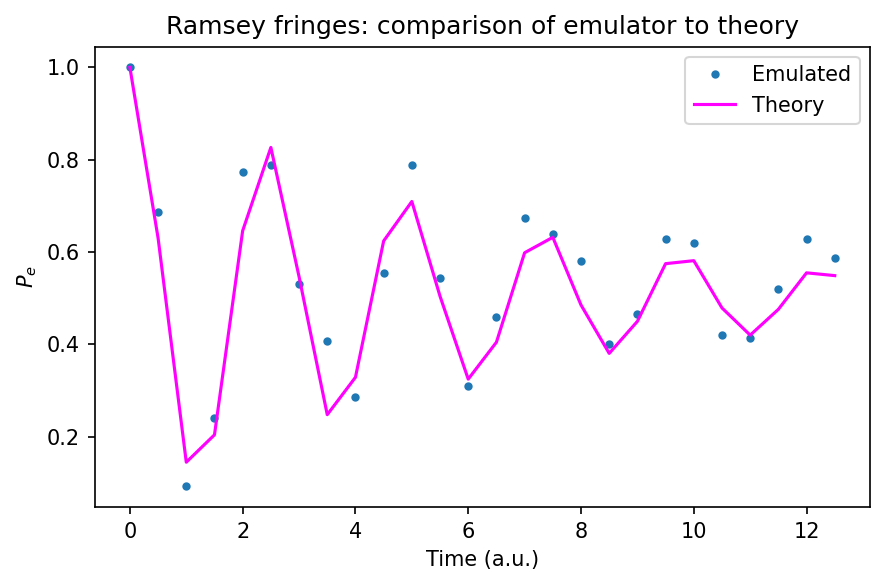

In [20]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts,[T2R_dist(t,T2R,Detuning) for t in ts],'-',color='magenta',label="Theory")
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Ramsey fringes: comparison of emulator to theory")
plt.tight_layout();